In [64]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
import numpy as np
from scipy.optimize import minimize

In [80]:
def hilbert_schmidt_test(U, Vconj):
    assert U.num_qubits == Vconj.num_qubits
    
    qc = QuantumCircuit(10, 10)
    
    for q in range(5):
        qc.h(q)
        qc.cx(q, q+5)
        
    qc.compose(U, [0, 1, 2,3,4], inplace=True)
    qc.compose(Vconj, [5, 6, 7,8,9], inplace=True)
    
    for q in range(4, -1, -1):
        qc.cx(q, q+5)
        qc.h(q)
    
    qc.measure_all(add_bits=False)
    
    qc.draw()
    return qc

In [81]:
def cost_function(theta, hst, sampler):
    # calculate the cost of Hilbert-Schmidt test based on the parameters theta
    qc = hst.assign_parameters(theta)
    result = sampler.run(qc).result()
    
    try:
        print('Hilbert-Schmidt distance:', result.quasi_dists[0][0], 'cost:', 1-result.quasi_dists[0][0])
        return 1-result.quasi_dists[0][0]
    except KeyError:
        return 1

In [82]:
def param_shift_gradient(theta, qc, sampler, theta_index=None):
    grad = []

    shifted_theta_list = []
    if theta_index is None:
        theta_index = range(len(theta))
    for i in theta_index:
        _theta = theta.copy()
        _theta[i] += np.pi/2
        shifted_theta_list.append(_theta)

        _theta = theta.copy()
        _theta[i] -= np.pi/2
        shifted_theta_list.append(_theta)

    result = sampler.run([qc]*len(shifted_theta_list), 
                         shifted_theta_list).result()

    for i in theta_index:
        grad_param = 0
        if 0 in result.quasi_dists[2*i].keys():
            grad_param += 0.5*result.quasi_dists[2*i][0]
        if 0 in result.quasi_dists[2*i+1].keys():
            grad_param -= 0.5*result.quasi_dists[2*i+1][0]
        grad.append(grad_param)

    return grad

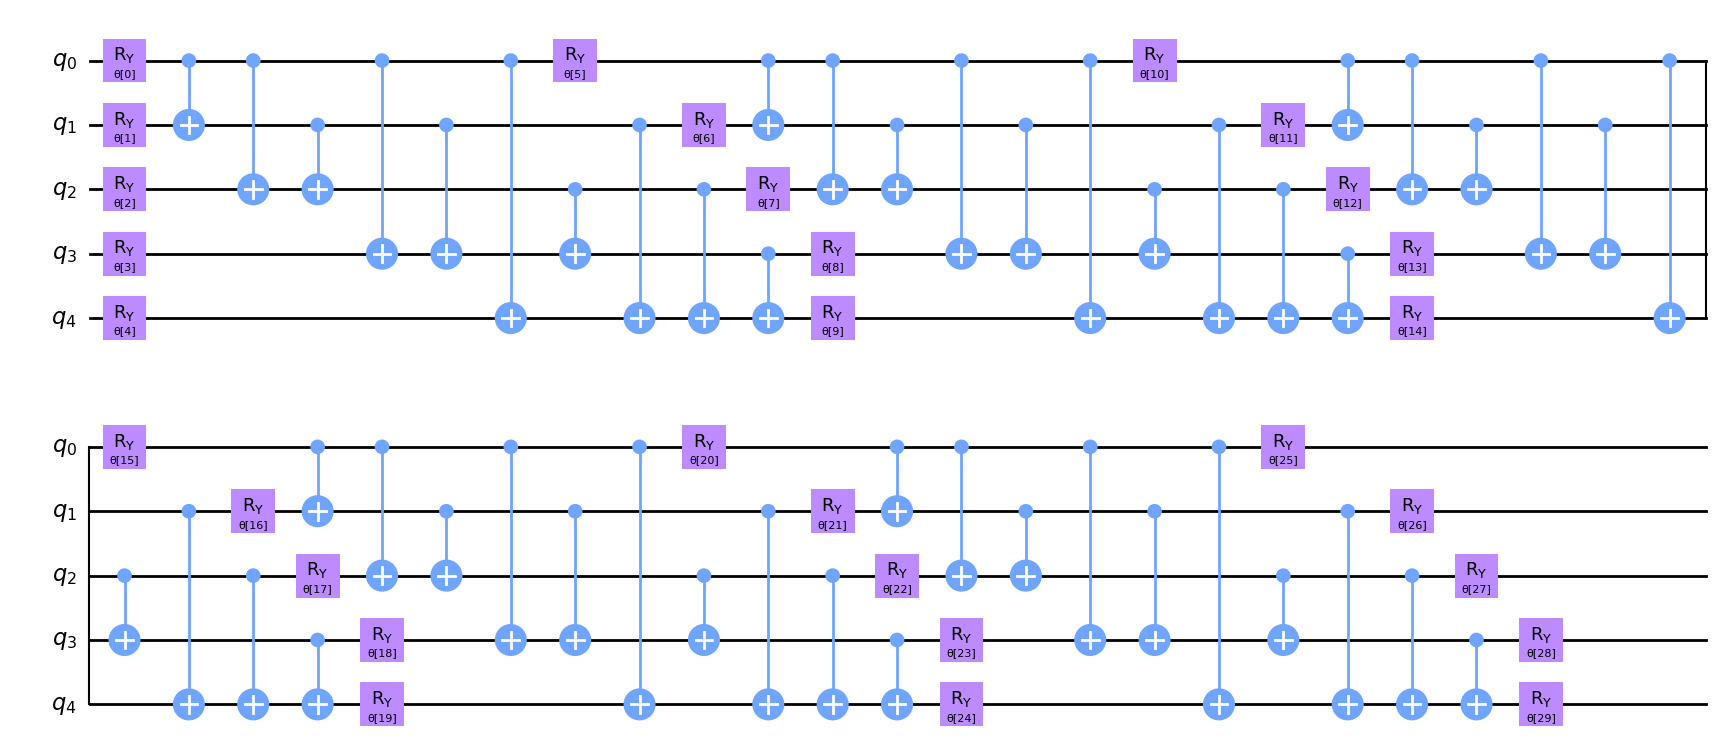

In [100]:
# preparing ansatz
ansatz = TwoLocal(5, 'ry', 'cx', 'full', reps=5)
# ENTER CODE ABOVE
ansatz = ansatz.decompose()
ansatz.draw()

In [101]:
Uk = QuantumCircuit(5)

Uk.initialize([0.07071067811865475, 0, 0.07071067811865475, 0, 0.1224744871391589, 0.1, 0, 0, 0.15811388300841897, 0, 0.1224744871391589, 0, 0, 0, 0, 0, 0.17320508075688773, 0, 0.282842712474619, 0, 0.1, 0, 0, 0, 0.7713624310270756, 0.1224744871391589, 0.4183300132670378, 0.1, 0.07071067811865475, 0, 0.07071067811865475, 0])

In [102]:
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
hst = hilbert_schmidt_test(Uk, ansatz)
sampler = Sampler()

def cost_function_wrapper(params):
    return cost_function(params, hst=hst, sampler=sampler)

def gradient_wrapper(params):
    return list(-np.array(param_shift_gradient(params, qc=hst, sampler=sampler)))


opt_result = minimize(cost_function_wrapper, initial_params, method='COBYLA', options={'disp': True, 'maxiter':5000})


# # ENTER CODE ABOVE

print(opt_result)

Hilbert-Schmidt distance: 0.0018603123959993 cost: 0.9981396876040007
Hilbert-Schmidt distance: 0.0006551606963649 cost: 0.999344839303635
Hilbert-Schmidt distance: 0.0011016582681916 cost: 0.9988983417318084
Hilbert-Schmidt distance: 0.0023616687984906 cost: 0.9976383312015094
Hilbert-Schmidt distance: 0.0001016373022327 cost: 0.9998983626977673
Hilbert-Schmidt distance: 0.0003892395592753 cost: 0.9996107604407247
Hilbert-Schmidt distance: 0.0001123840507829 cost: 0.999887615949217
Hilbert-Schmidt distance: 0.0005291939927859 cost: 0.999470806007214
Hilbert-Schmidt distance: 0.0001569479916871 cost: 0.9998430520083129
Hilbert-Schmidt distance: 3.3215581403e-06 cost: 0.9999966784418597
Hilbert-Schmidt distance: 0.0074928543901186 cost: 0.9925071456098814
Hilbert-Schmidt distance: 0.0001212423806522 cost: 0.9998787576193477
Hilbert-Schmidt distance: 0.0001306412166521 cost: 0.9998693587833479
Hilbert-Schmidt distance: 0.0004107856396002 cost: 0.9995892143603998
Hilbert-Schmidt distance:

In [91]:
bh_conj = ansatz.assign_parameters(opt_result.x)
bh_conj.name = 'Ua'

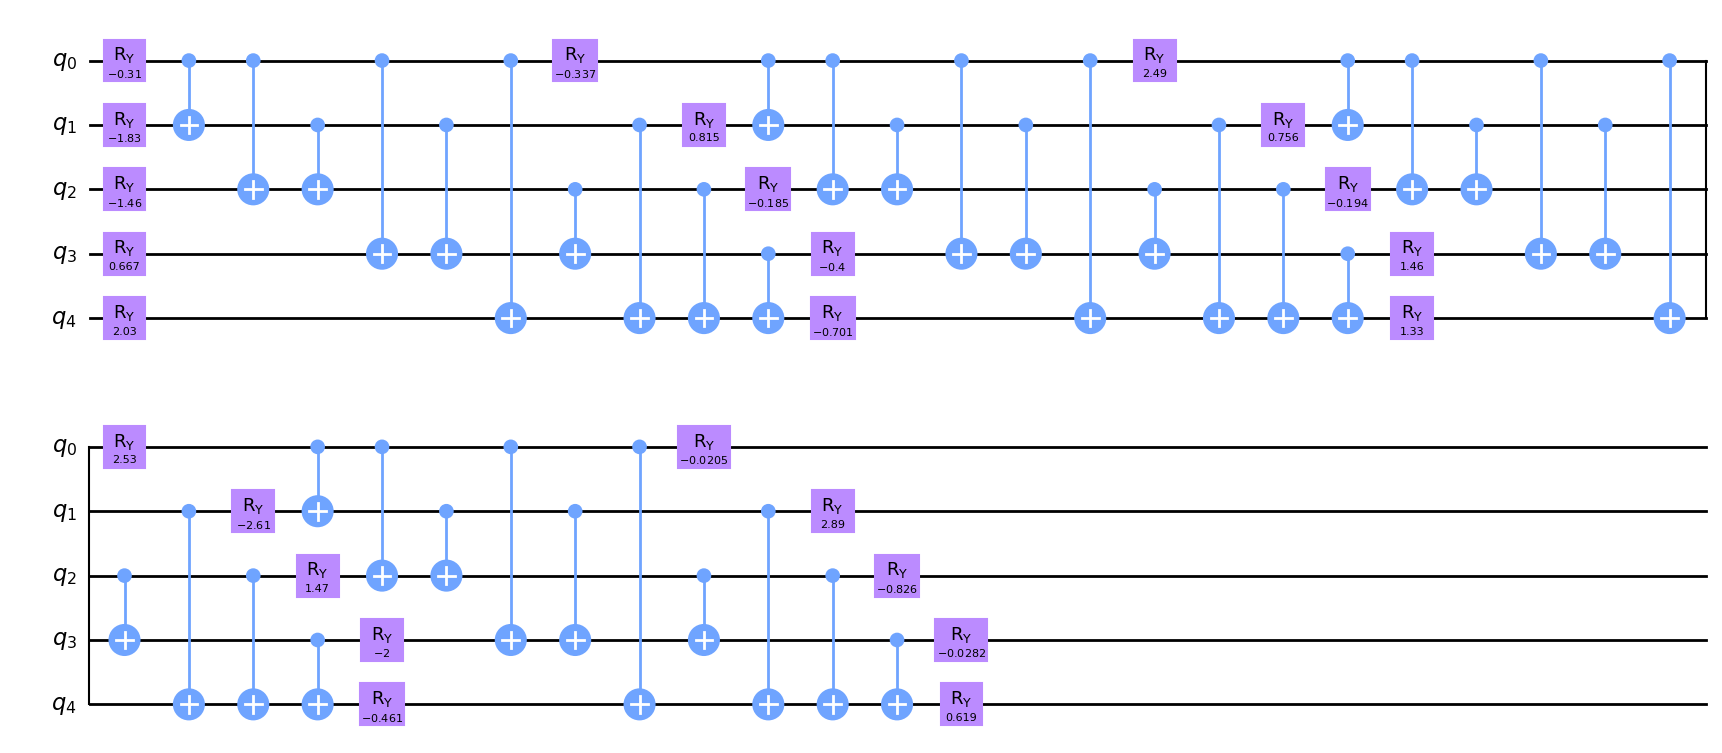

In [92]:
bh_conj.draw()

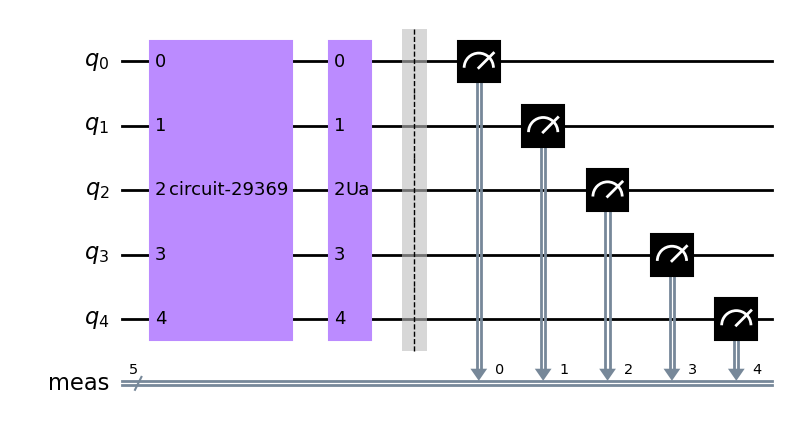

In [95]:
qc2 = QuantumCircuit(5)
qc2.append(Uk, [0,1,2,3,4])
qc2.append(bh_conj, [0,1,2,3,4])
qc2.measure_all()
qc2.draw()

In [96]:
s = Sampler()
results = s.run(circuits=qc2).result()

In [97]:
print(results)

SamplerResult(quasi_dists=[{0: 1.9087125473e-05, 1: 5.7697861429e-05, 2: 0.000183915417186, 3: 6.9402009631e-05, 4: 0.002601179397038, 5: 0.002754215739061, 6: 0.001052641106139, 7: 0.002422333170656, 8: 0.093807626057714, 9: 0.003443633628619, 10: 0.040409433464904, 11: 0.001177089507799, 12: 0.001385004405952, 13: 0.092304205920545, 14: 0.051626287875468, 15: 0.016268808415702, 16: 6.2574164362e-05, 17: 0.018048071838287, 18: 0.024711484212409, 19: 0.000271765397795, 20: 0.000333130304724, 21: 0.03454270429438, 22: 0.060611855992614, 23: 0.001804161723871, 24: 0.017928453355493, 25: 0.000198404918338, 26: 0.057480509832967, 27: 0.014951547208295, 28: 0.251040958333764, 29: 0.106359805427077, 30: 0.093985175143494, 31: 0.008086836748812}], metadata=[{}])


In [98]:
print(bh_conj)

     ┌──────────────┐                              ┌──────────────┐     »
q_0: ┤ Ry(-0.30971) ├──■────■─────────■─────────■──┤ Ry(-0.33743) ├─────»
     ├─────────────┬┘┌─┴─┐  │         │         │  └──────────────┘     »
q_1: ┤ Ry(-1.8257) ├─┤ X ├──┼────■────┼────■────┼────────────────────■──»
     ├─────────────┤ └───┘┌─┴─┐┌─┴─┐  │    │    │                    │  »
q_2: ┤ Ry(-1.4599) ├──────┤ X ├┤ X ├──┼────┼────┼─────────■──────────┼──»
     ├─────────────┤      └───┘└───┘┌─┴─┐┌─┴─┐  │       ┌─┴─┐        │  »
q_3: ┤ Ry(0.66672) ├────────────────┤ X ├┤ X ├──┼───────┤ X ├────────┼──»
     └┬────────────┤                └───┘└───┘┌─┴─┐     └───┘      ┌─┴─┐»
q_4: ─┤ Ry(2.0271) ├──────────────────────────┤ X ├────────────────┤ X ├»
      └────────────┘                          └───┘                └───┘»
«                                                                        »
«q_0: ──────────────────────■───────────────■───────────────■─────────■──»
«     ┌─────────────┐     ┌─┴─┐     

In [ ]:
res = {'0': 0.13,
 '1': 0.12,
 '2': 0.11,
 '3': 0.11,
 '4': 0.17,
 '5': 0.15,
 '6': 0.095,
 '7': 0.115}

qubit = {}